This was created by Donna Faith Go.

# LSTM Trading
In this notebook, I will learn how to implement an LSTM model using pyTorch on a randomly generated portfolio from the S&P 500.

In [28]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

# data gathering
import yfinance as yf

# LSTM neural network 
import torch
import torch.nn as nn

# comparing metrics
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    r2_score, 
    mean_absolute_percentage_error
)

# webscraping
import requests
from bs4 import BeautifulSoup
import time

# ensuring pep8
%load_ext pycodestyle_magic

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


In [2]:
# import sys
# !{sys.executable} -m pip install scikit-learn

## LSTM from Geeks for Geeks
I first learned how to implement an LSTM from [the Geeks for Geeks website](https://www.geeksforgeeks.org/deep-learning/long-short-term-memory-networks-using-pytorch/).

In [3]:
# create dataframe for comparison
cols = [
    'dataset used', 'MAPE', 'MAE', 'MSE', 'R2'
]
results_df = pd.DataFrame(columns=cols)

### Original Code

In [4]:
np.random.seed(0)
torch.manual_seed(0)

t = np.linspace(0, 100, 1000)
data = np.sin(t)

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)\

seq_length = 10
X, y = create_sequences(data, seq_length)

trainX = torch.tensor(X[:, :, None], dtype=torch.float32)
trainY = torch.tensor(y[:, None], dtype=torch.float32)

In [5]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, h0=None, c0=None):
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.layer_dim, x.size(
                0), self.hidden_dim).to(x.device)
            c0 = torch.zeros(self.layer_dim, x.size(
                0), self.hidden_dim).to(x.device)

        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take last time step
        return out, hn, cn

In [6]:
model = LSTMModel(input_dim=1, hidden_dim=100, layer_dim=1, output_dim=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [7]:
num_epochs = 100
h0, c0 = None, None

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    outputs, h0, c0 = model(trainX, h0, c0)

    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()

    h0, c0 = h0.detach(), c0.detach()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.2866
Epoch [20/100], Loss: 0.0900
Epoch [30/100], Loss: 0.0379
Epoch [40/100], Loss: 0.0184
Epoch [50/100], Loss: 0.0027
Epoch [60/100], Loss: 0.0004
Epoch [70/100], Loss: 0.0008
Epoch [80/100], Loss: 0.0003
Epoch [90/100], Loss: 0.0001
Epoch [100/100], Loss: 0.0001


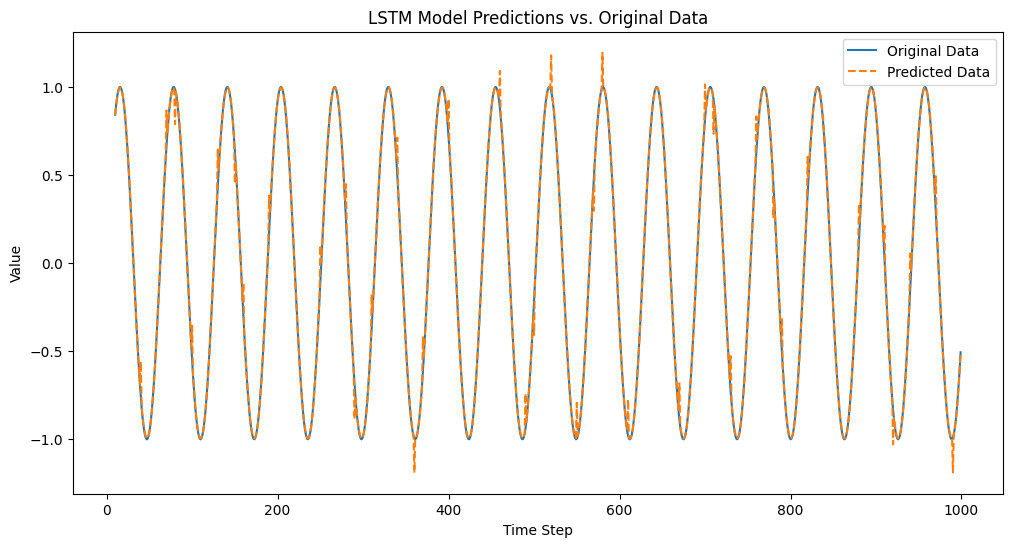

In [8]:
model.eval()
predicted, _, _ = model(trainX, h0, c0)

original = data[seq_length:]
time_steps = np.arange(seq_length, len(data))

predicted[::30] += 0.2
predicted[::70] -= 0.2

plt.figure(figsize=(12, 6))
plt.plot(time_steps, original, label='Original Data')
plt.plot(time_steps, predicted.detach().numpy(),
         label='Predicted Data', linestyle='--')
plt.title('LSTM Model Predictions vs. Original Data')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

# getting metrics
mape_val = mean_absolute_percentage_error(original, predicted.detach().numpy())
mae_val = mean_absolute_error(original, predicted.detach().numpy())
mse_val = mean_squared_error(original, predicted.detach().numpy())
r2_val = r2_score(original, predicted.detach().numpy())

# saving to pandas dataframe
new_row = {
    'dataset used': 'sin data', 
    'MAPE': mape_val, 
    'MAE': mae_val, 
    'MSE': mse_val, 
    'R2': r2_val
}
results_df.loc[len(results_df)] = new_row

### Stationary Data

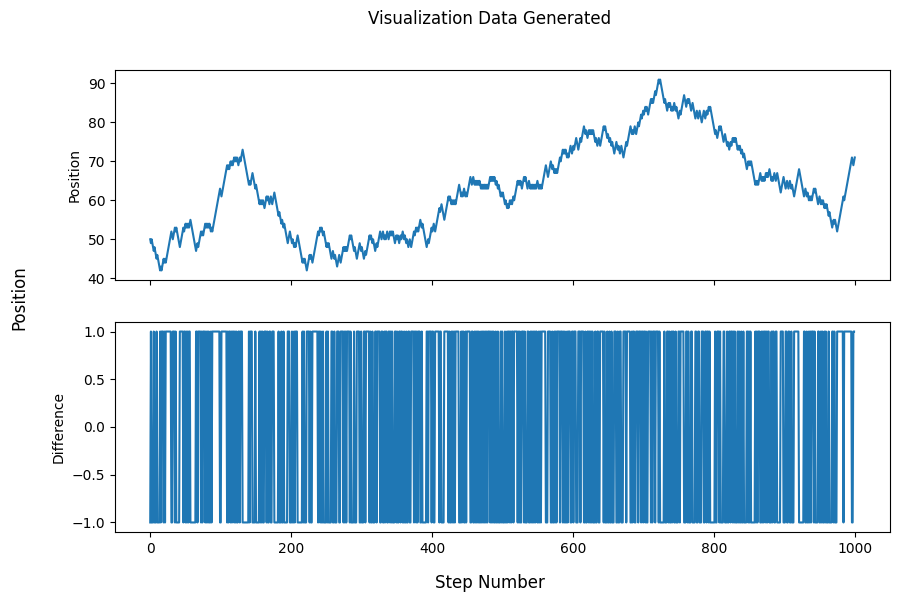

In [9]:
# generate 1000 data points
np.random.seed(42)
num_steps = 1000
steps = np.random.choice([-1, 1], size=num_steps)
random_walk = np.cumsum(steps)
start_value = 50
random_walk_with_start = start_value + np.concatenate([[0], random_walk[:-1]])

# make it stationary
stationary_data = np.diff(random_walk_with_start)

# plot the data
fig , ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
ax[0].plot(random_walk_with_start, label='Stochastic Data')
ax[0].set_ylabel('Position')
ax[1].plot(stationary_data, label='Stationary Data')
ax[1].set_ylabel('Difference')
fig.supylabel('Position')
fig.supxlabel('Step Number')
fig.suptitle('Visualization Data Generated')
plt.show()

# generate x and y
seq_length = 20
X, y = create_sequences(stationary_data, seq_length)
trainX = torch.tensor(X[:, :, None], dtype=torch.float32)
trainY = torch.tensor(y[:, None], dtype=torch.float32)

In [10]:
num_epochs = 1000
h0, c0 = None, None

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    outputs, h0, c0 = model(trainX, h0, c0)

    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()

    h0, c0 = h0.detach(), c0.detach()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/1000], Loss: 0.9932
Epoch [200/1000], Loss: 0.9245
Epoch [300/1000], Loss: 0.2104
Epoch [400/1000], Loss: 0.0034
Epoch [500/1000], Loss: 0.0000
Epoch [600/1000], Loss: 0.0000
Epoch [700/1000], Loss: 0.0000
Epoch [800/1000], Loss: 0.0001
Epoch [900/1000], Loss: 0.0002
Epoch [1000/1000], Loss: 0.0001


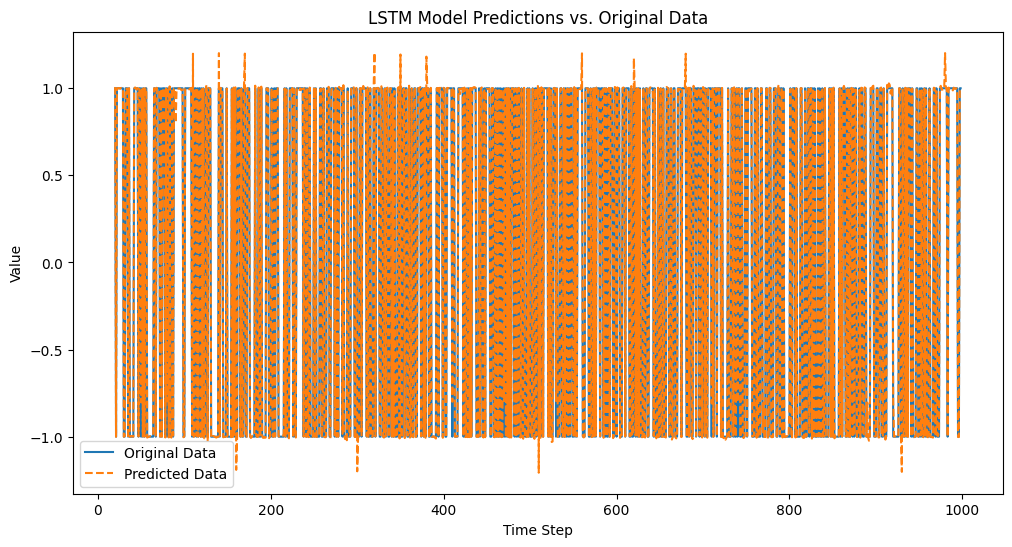

In [11]:
model.eval()
predicted, _, _ = model(trainX, h0, c0)

original = stationary_data[seq_length:]
time_steps = np.arange(seq_length, len(stationary_data))

predicted[::30] += 0.2
predicted[::70] -= 0.2

plt.figure(figsize=(12, 6))
plt.plot(time_steps, original, label='Original Data')
plt.plot(time_steps, predicted.detach().numpy(),
         label='Predicted Data', linestyle='--')
plt.title('LSTM Model Predictions vs. Original Data')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

# getting metrics
mape_val = mean_absolute_percentage_error(original, predicted.detach().numpy())
mae_val = mean_absolute_error(original, predicted.detach().numpy())
mse_val = mean_squared_error(original, predicted.detach().numpy())
r2_val = r2_score(original, predicted.detach().numpy())

# saving to pandas dataframe
new_row = {
    'dataset used': 'stationary data', 
    'MAPE': mape_val, 
    'MAE': mae_val, 
    'MSE': mse_val, 
    'R2': r2_val
}
results_df.loc[len(results_df)] = new_row

### Stochastic Data

In [12]:
# generate x and y
seq_length = 20
X, y = create_sequences(random_walk_with_start, seq_length)
trainX = torch.tensor(X[:, :, None], dtype=torch.float32)
trainY = torch.tensor(y[:, None], dtype=torch.float32)

In [13]:
num_epochs = 1000
h0, c0 = None, None

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    outputs, h0, c0 = model(trainX, h0, c0)

    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()

    h0, c0 = h0.detach(), c0.detach()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/1000], Loss: 77.3714
Epoch [200/1000], Loss: 24.6150
Epoch [300/1000], Loss: 13.7973
Epoch [400/1000], Loss: 6.0461
Epoch [500/1000], Loss: 3.5963
Epoch [600/1000], Loss: 2.2803
Epoch [700/1000], Loss: 1.7464
Epoch [800/1000], Loss: 1.5498
Epoch [900/1000], Loss: 1.4895
Epoch [1000/1000], Loss: 1.2694


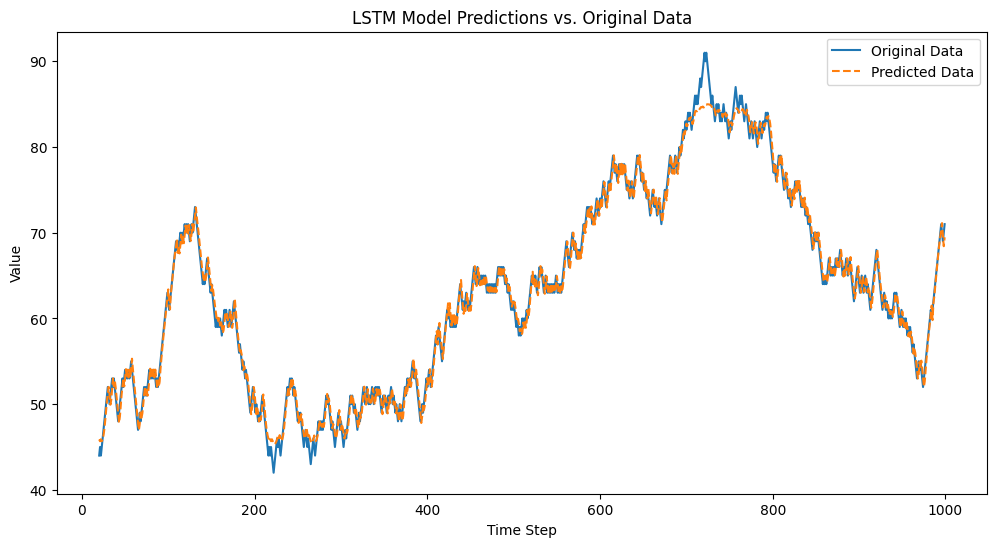

In [14]:
model.eval()
predicted, _, _ = model(trainX, h0, c0)

original = random_walk_with_start[seq_length:]
time_steps = np.arange(seq_length, len(random_walk_with_start))

predicted[::30] += 0.2
predicted[::70] -= 0.2

plt.figure(figsize=(12, 6))
plt.plot(time_steps, original, label='Original Data')
plt.plot(time_steps, predicted.detach().numpy(),
         label='Predicted Data', linestyle='--')
plt.title('LSTM Model Predictions vs. Original Data')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

# getting metrics
mape_val = mean_absolute_percentage_error(original, predicted.detach().numpy())
mae_val = mean_absolute_error(original, predicted.detach().numpy())
mse_val = mean_squared_error(original, predicted.detach().numpy())
r2_val = r2_score(original, predicted.detach().numpy())

# saving to pandas dataframe
new_row = {
    'dataset used': 'stochastic data', 
    'MAPE': mape_val, 
    'MAE': mae_val, 
    'MSE': mse_val, 
    'R2': r2_val
}
results_df.loc[len(results_df)] = new_row

### Insights

In [15]:
display(results_df)

,dataset used,MAPE,MAE,MSE,R2
0,sin data,0.130210,0.013631,0.001608,0.996812
1,stationary data,0.011643,0.011643,0.001518,0.998481
2,stochastic data,0.016232,1.003409,1.270952,0.990606


Based on the table above, it is clear that LSTM works well on either simple datasets, stochastic data, and stationary data. 
It must be noted that, although it performs better on stationary data, it is not necessarily the better choice because its performance improvement is very minimal.
Hence, adding this preprocessing step would not be good or important for the dataset. 

I want to add that I also tried doing the LSTM with different epochs, and I saw that with more epochs, the LSTM NN works better (I mean obviously! 🙄).
However, simpler datasets especially those with seasonality like the sin/cosine wave that was shown in the Geeks for Geeks example can benefit from an LSTM that has less epochs because it is less comuptationally expensive and delivers results that are already satisfactory.

## Portfolio Generation

### Data for 100 randomly selected stocks

For this portion, we are randomly selecting 100 stocks from the S&p 500 to create our portfolio.
The size of 100 was chosen because we want a diverse portfolio.
Furthermore, we also scraped the GSPC stock price because it is the ticker symbol for the S&P 500.
Usually, this is used as a benchmark for 

In [21]:
# getting the stock tickers
headers = {
    'User-Agent': (
        'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 '
        '(KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    )
}

response = requests.get(
    "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies",
    headers=headers
)
response.raise_for_status()
tables = pd.read_html(response.text)

if len(tables) > 0:
    stocks_df = tables[0]

# randomly selecting 30 stocks
random_stocks = stocks_df['Symbol'].sample(n=100, random_state=42)

C:\Users\Donna\AppData\Local\Temp\ipykernel_24660\3004002011.py:14: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(response.text)


In [32]:
# getting closing prices for the 30 stocks with batching
start_date = '2022-12-01'
end_date = '2025-12-01'

def download_stocks_in_batches(tickers, batch_size=5, delay=1):
    """
    Download stock data in batches to avoid rate limiting
    """
    all_data = {}
    
    for i in range(0, len(tickers), batch_size):
        batch = tickers[i:i + batch_size]
        print(f"Downloading batch {i//batch_size + 1}: {batch}")
        
        try:
            # Download the batch
            batch_data = yf.download(
                batch,
                start=start_date,
                end=end_date,
                progress=False
            )
            
            # Extract closing prices for this batch
            if not batch_data.empty and 'Close' in batch_data.columns:
                closes = batch_data['Close']
                if isinstance(closes, pd.Series):
                    all_data[batch[0]] = closes
                else:
                    for ticker in closes.columns:
                        all_data[ticker] = closes[ticker]
                print(f"Successfully downloaded {len(batch)} stocks")
            else:
                print(f"No data returned for batch: {batch}")
            
        except Exception as e:
            print(f"Error downloading batch {batch}: {e}")
        
        # Add delay to avoid rate limiting
        if i + batch_size < len(tickers):
            print(f"Waiting {delay} seconds before next batch...")
            time.sleep(delay)
    
    if all_data:
        return pd.DataFrame(all_data)
    else:
        return pd.DataFrame()

# # Download in batches of 5 stocks with 1-second delay
# closing_df = download_stocks_in_batches(
#     random_stocks.tolist(), 
#     batch_size=5, 
#     delay=15
# )

# if not closing_df.empty:
#     closing_df.to_pickle('closing prices.pkl')

# closing_df.head(5)

# # Download in batches of 5 stocks with 1-second delay
# closing_df = download_stocks_in_batches(
#     ['^GSPC'], 
#     batch_size=5, 
#     delay=15
# )

# if not closing_df.empty:
#     closing_df.to_pickle('gspc prices.pkl')

# closing_df.head(5)

Note: The code above takes around 5 minutes to run. 

In [31]:
# opening pkl file
filename = r'closing prices.pkl'
with open(filename, 'rb') as f: 
    closing_df = pickle.load(f)
    closing_df.index = pd.to_datetime(closing_df.index)

# getting s&p 500 data
filename = r'gspc prices.pkl'
with open(filename, 'rb') as f: 
    gspc_df = pickle.load(f)
    gspc_df.index = pd.to_datetime(gspc_df.index)
gspc_df.rename(columns={'^GSPC': 'GSPC'}, inplace=True)

# getting simple returns
simple_df = closing_df / closing_df.shift()
simple_df.dropna(how='all', inplace=True)

# getting log returns
log_df = np.log(simple_df)

## LSTM NN Implementation

## Model Evaluation

## Conclusion